In [1]:
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [7]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(n_inputs, 16)
        self.logits = nn.Linear(16, n_outputs)
        
    def forward(self, state):
        x = F.relu(self.hidden(torch.FloatTensor(state)))
        x = F.softmax(self.logits(x), dim=-1)
        return x

In [8]:
class REINFORCE():
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.mlp = MLP(self.env.observation_space.shape[0], self.env.action_space.n)
        self.optim = Adam(params=self.mlp.parameters(), lr=1e-3)
    
    # generate action from categorical distribution using action probability
    def get_action(self, state):
        action_probs = self.mlp(state)
        distro = Categorical(action_probs)
        return distro.sample().item()
    
    def discount_rewards(self, reward_list, gamma=0.99):
        G = torch.tensor([np.sum(reward_list[i:] * (gamma ** np.array(range(i, len(reward_list))))) for i in range(len(reward_list))])
        return G
    
    def loss(self, state_list, action_list, reward_list):
        self.optim.zero_grad()
        future_return = self.discount_rewards(reward_list)
        G = torch.tensor(np.sum(reward_list))
        action_prob = self.mlp(state_list)
        dist = Categorical(action_prob)
        log_prob = -dist.log_prob(action_list)
        loss = torch.sum(log_prob * G)
        loss.backward()
        self.optim.step()
        
    def learn(self):
        returns = []
        mean_return = []
        episode_len = 1000
        solved = False
        for episode in range(episode_len):
            states = []
            actions = []
            rewards = []
            state = self.env.reset()
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                # store states, actions and rewards for gradient descent
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                state = next_state
            
            self.loss(torch.FloatTensor(states), torch.LongTensor(actions), np.array(rewards))
            returns.append(np.sum(rewards))
            mean_return.append(np.mean(returns[-100:]))
            if np.mean(returns[-100:]) >= 195.0 and not solved:
                print(f'Solved CartPole in {episode} episodes :)')
                solved = True
            elif episode + 1 == episode_len:
                print('You failed.')
                
        return returns, mean_return
    
    def act(self, rational=True):
        episode_len = 3 if rational else 5
        with torch.no_grad():
            for episode in range(episode_len):
                state = self.env.reset()
                done = False
                while not done:
                    self.env.render()
                    action = self.get_action(state) if rational else np.random.choice([0,1])
                    next_state, reward, done, _ = self.env.step(action)
                    state = next_state
        self.env.close()
        
    def plot(self, returns, mean_returns):
        plt.plot(returns, label='Episodic Return')
        plt.plot(mean_returns, label='Mean Return')
        plt.title('REINFORCE Training Curve')
        plt.legend()
        plt.xlabel('Episodes')
        plt.ylabel('Total Return')
        plt.show()

Solved CartPole in 747 episodes :)


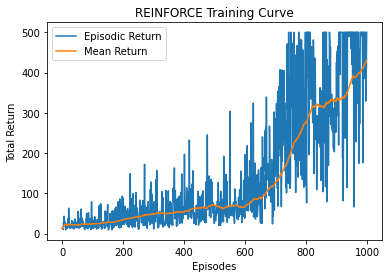

In [9]:
if __name__ == '__main__':
    reinforce = REINFORCE()
    returns, mean_returns = reinforce.learn()
    reinforce.plot(returns, mean_returns)
    reinforce.act()